## Set parameters

In [ ]:
import os

from utils.loaders import load_mnist
from models.AE import Autoencoder

# Autoencoder
This is a sample of chapter 3.
In this chapter, we learn what is autoencoder. Auto-encoder is a complex mathematical model which trains on unlabeled as well as unclassified data and is used to map the input data to another compressed feature representation and from that feature representation reconstructing back the input data. An autoencoder is composed of an encoder(An encoder network that compresses high-dimensional input data into a lower-dimensional representation vector) and a decoder(A decoder network that decompresses a given representation vector back to the original domain) sub-models.
There is a nice story in this book. Suppose there are two brothers Mr.N Coder and Mr.D Coder and they have an exhibition.
When a new painting arrives for display, Mr. N. Coder simply chooses a point on the wall to represent the painting, places a marker at this point, then throws the original artwork away. When a customer requests to see the painting, Mr. D. Coder attempts to re-create the artwork using just the coordinates of the relevant marker on the wall.
Mr. N. Coder and Mr. D. Coder are using representation vectors inside a two-dimensional latent space (the wall) to encode each image.
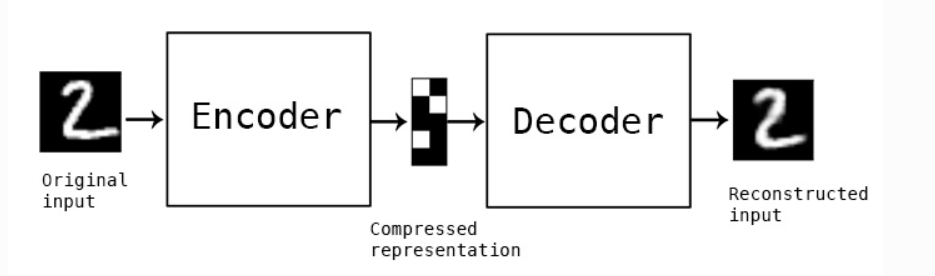

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

## Load the data
MNIST contains a collection of 70,000, 28 x 28 images of handwritten digits from 0 to 9.

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Define the structure of the neural network
In an autoencoder, the encoder's job is to take the input image and map it to a point in the latent space. For the encoder, the authors used standard Convolutional Layer.

### Standard Convolutional Layer:
A standard convolutional layer on an input of size ixi is defined by the following two parameters.
<ul>
  <li>Padding (p): The number of zeros padded around the original input increasing the size to (i+2*p)x(i+2*p)</li>
  <li>Stride (s): The amount by which the kernel is shifted when sliding across the input image.</li>
</ul>

The figure below shows how a convolutional layer works as a two-step process.

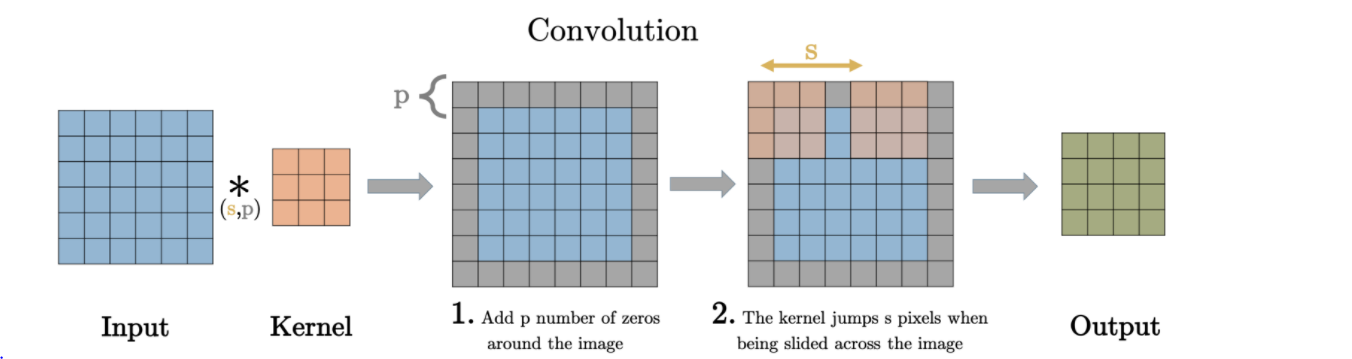

In [8]:

AE = Autoencoder(
    #Size of the vocabulary
    input_dim = (28,28,1)
    
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    #two-dimensional latent space
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [9]:
#There are 3 steps to encoding in AE.py
#Defining the input to the encoder (the image).
#Stacking convolutional layers sequentially on top of each other.
#Flattening the last convolutional layer to a vector to the 2D latent space.
#Also the model that defines the encoder is the Keras —a model that takes an input image and encodes it into the 2D latent space.
AE.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

For decode the author used convolutional transpose layers.

### Transposed Convolutional Layer:
A transposed convolutional layer, is usually carried out for upsampling i.e. to generate an output feature map that has a spatial dimension greater than that of the input feature map. Just like the standard convolutional layer, the transposed convolutional layer is also defined by the padding and stride. These values of padding and stride are the one that hypothetically was carried out on the output to generate the input. i.e. if you take the output, and carry out a standard convolution with stride and padding defined, it will generate the spatial dimension same as that of the input.
Implementing a transposed convolutional layer can be better explained as a 4 step process
<ul>
  <li>Step 1: Calculate new parameters z and p’</li>
  <li>Step 2: Between each row and columns of the input, insert z number of zeros. This increases the size of the input to (2*i-1)x(2*i-1)</li>
  <li>Step 3: Pad the modified input image with p’ number of zeros</li>
  <li>Step 4: Carry out standard convolution on the image generated from step 3 with a stride length of 1</li>
</ul>
The complete steps can be seen in the figure below.

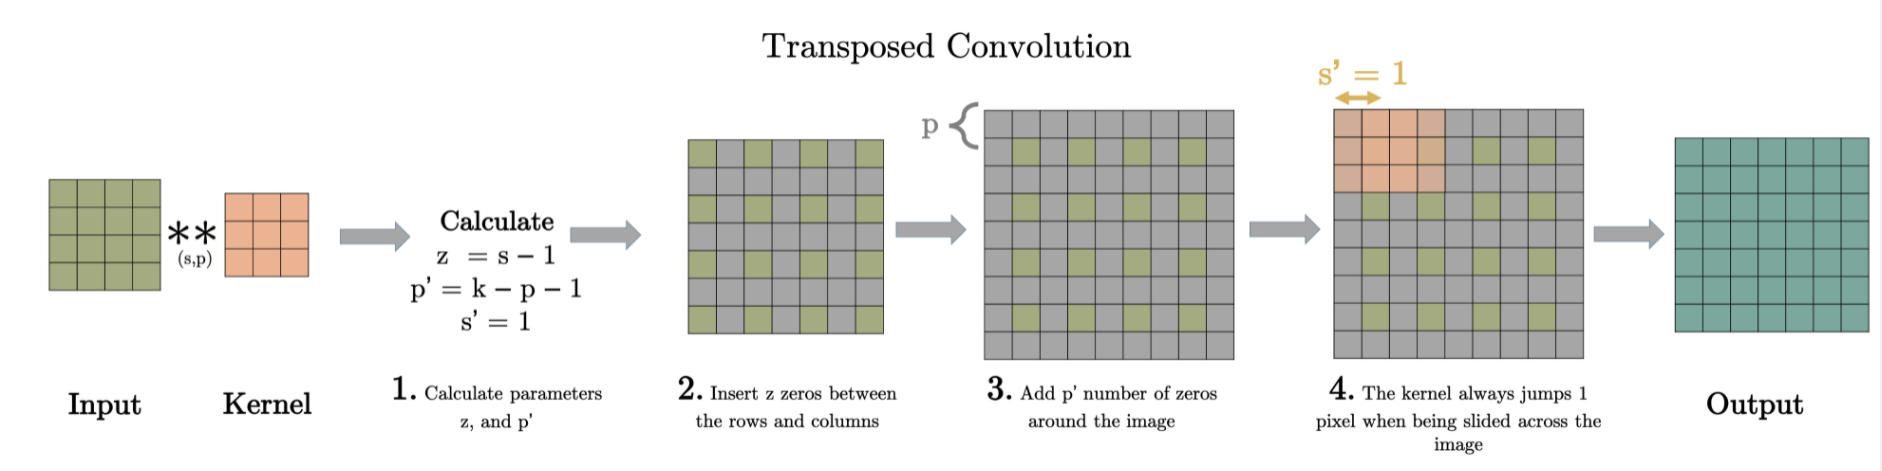

In [10]:
#There are 4 steps to decoding in AE.py
#Defining the input to the decoder (the point in the latent space).
#Connecting the input to a Dense layer.
#Reshapping this vector into a tensor that can be fed as input into the first convolutional transpose layer
#Stack convolutional transpose layers on top of each other.
#Also, the model that defines the decoder is the Keras—a model that takes a point in the latent space and decodes it into the original image domain.
AE.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

## Train the autoencoder

In [11]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [ ]:
AE.compile(LEARNING_RATE)

In [13]:
#the loss function is root mean squared error (RMSE) 
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

W1120 20:44:46.057298 11040 deprecation_wrapper.py:119] From D:\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1120 20:44:46.552623 11040 deprecation_wrapper.py:119] From D:\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/200
 128/1000 [==>...........................] - ETA: 17s - loss: 0.2303

D:\anaconda3\envs\generative\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.191820). Check your callbacks.
  % delta_t_median)


1000/1000 [==============================] - 4s 4ms/step - loss: 0.1876

Epoch 00001: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 2/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0848

Epoch 00002: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 3/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0667

Epoch 00003: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 4/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0601

Epoch 00004: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 5/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0571

Epoch 00005: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 6/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0558

Epoch 00006: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 7/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0549

Epoch 000

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0432

Epoch 00054: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 55/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0430

Epoch 00055: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 56/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0428A: 0s - loss: 0 - ETA: 0s - 

Epoch 00056: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 57/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0427

Epoch 00057: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 58/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0427

Epoch 00058: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 59/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0422

Epoch 00059: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 60/200
1000/1000 [==============================] - 2s 

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0358

Epoch 00158: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 159/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0362A: 0s - l

Epoch 00159: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 160/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0360

Epoch 00160: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 161/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0361

Epoch 00161: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 162/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0359

Epoch 00162: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 163/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0358A: 1s - loss: 0.0 - ETA: 0s

Epoch 00163: saving model to run/vae/0001_digits\weights/weights.h5
Epoch 164/200
1000/1000 [=======================